<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you:

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should:

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf

# data cleaning / tokenizing
import re
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS

# text preprocessing
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# model building
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.callbacks import EarlyStopping

# split data into train and test set
from sklearn.model_selection import train_test_split

# plot lib
import matplotlib.pyplot as plt

# score handling
from sklearn.metrics import confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/AT&T_Spam_Detector/spam.csv',encoding='ISO-8859-1')
display (df.head())
print (df.shape)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


(5572, 5)


In [4]:
# Statistiques basiques
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*df.isnull().sum()/df.shape[0])

Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [5]:
df.v1.value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

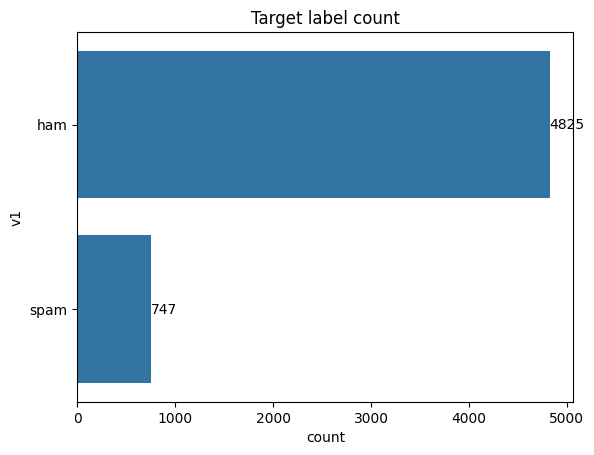

In [6]:
ax = sns.countplot(df['v1'])
for container in ax.containers:
    ax.bar_label(container)
plt.title('Target label count')
plt.show()

## Data Cleaning

In [7]:
# Remplacer les valeurs NaN par des chaînes vides
df['Unnamed: 2'].fillna('', inplace=True)
df['Unnamed: 3'].fillna('', inplace=True)
df['Unnamed: 4'].fillna('', inplace=True)

# Concaténer les colonnes à 'v2'
df['v2'] = df['v2'] + df['Unnamed: 2'] + df['Unnamed: 3'] + df['Unnamed: 4']

# Supprimer les colonnes inutiles
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

df = df.rename(columns={"v1":"label", "v2":"sms_content"})
df['label'] = df['label'].map( {'spam': 1, 'ham': 0} )

# Afficher les premières lignes du dataframe modifié
df.head()

,label,sms_content
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Ajouter une nouvelle colonne 'word_count' au DataFrame
df['word_count'] = df['sms_content'].apply(lambda x: len(x.split(' ')))
# Cette ligne de code calcule le nombre de mots dans chaque message SMS
# en utilisant la méthode split() pour diviser le texte en mots,
# puis en utilisant len() pour compter le nombre de mots.

In [9]:
df.groupby('label')['word_count'].agg(['count', 'mean', 'median'])
df.head()

,label,sms_content,word_count
0,0,"Go until jurong point, crazy.. Available only ...",20
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,0,U dun say so early hor... U c already then say...,11
4,0,"Nah I don't think he goes to usf, he lives aro...",13


In [10]:
df['word_count'].max()

171

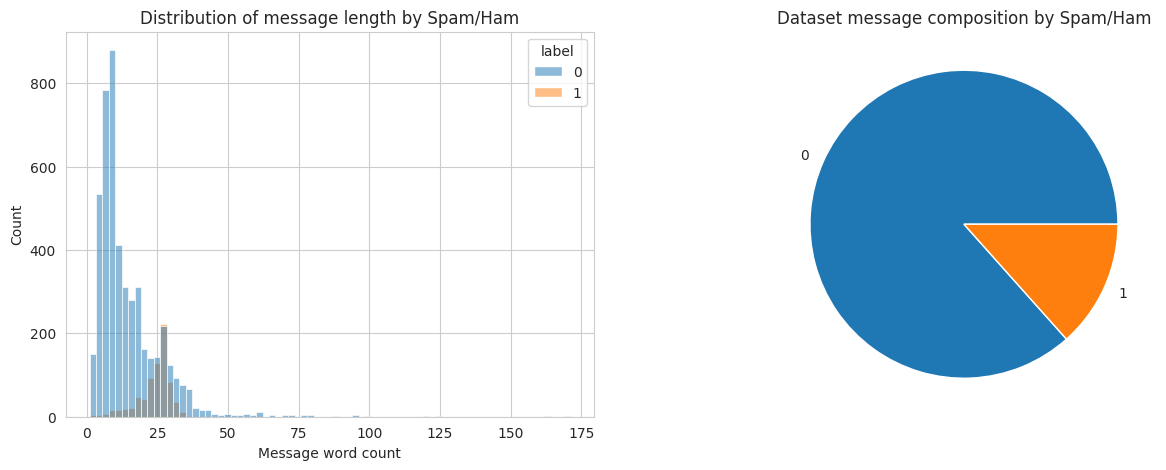

In [11]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
sns.histplot(data=df,
             x="word_count",
             hue="label",
             bins=75,
             ax=ax[0],
             legend=True).set_title('Distribution of message length by Spam/Ham')
ax[0].set_xlabel('Message word count')
ax[0].set_ylabel('Count')

ax[1].pie(df.label.value_counts(normalize=True),
            labels = ['0','1'])
ax[1].set_title('Dataset message composition by Spam/Ham')
# plt.savefig('images/eda.png',bbox_inches='tight',dpi=400, pad_inches=0.1)
plt.show()

In [12]:
# Charger le modèle spaCy en anglais
nlp = spacy.load('en_core_web_sm')

# Nettoyer le contenu des SMS
df["clean_content"] = df["sms_content"].apply(
    lambda x: ''.join(ch for ch in x if ch.isalnum() or ch == " " or ch == "'")
)
# Cette étape supprime tous les caractères non alphanumériques à l'exception des espaces et des apostrophes.

# Remplacer les espaces multiples par un seul espace, convertir en minuscules et supprimer les espaces en début et fin
df["clean_content"] = df["clean_content"].apply(
    lambda x: ' '.join(x.split()).lower().strip()
)

# Lemmatizer les tokens et supprimer les stopwords
df["clean_content"] = df["clean_content"].apply(
    lambda x: " ".join(
        [token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]
    )
)
# Cette étape lemmatise chaque token et supprime les stopwords, en utilisant le modèle spaCy.

In [13]:
df.head()

,label,sms_content,word_count,clean_content
0,0,"Go until jurong point, crazy.. Available only ...",20,jurong point crazy available bugis n great wor...
1,0,Ok lar... Joking wif u oni...,6,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,0,U dun say so early hor... U c already then say...,11,u dun early hor u c
4,0,"Nah I don't think he goes to usf, he lives aro...",13,nah think usf live


In [14]:
X = df['clean_content']
y = df['label']

In [15]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.3)

In [16]:
# Définir le nombre maximal de mots à considérer et la longueur maximale des séquences
max_words = 5000
max_len = 150

# Initialiser le tokenizer avec le nombre maximal de mots
tokenizer = Tokenizer(num_words=max_words)

# Adapter le tokenizer sur les textes d'entraînement
tokenizer.fit_on_texts(xtrain)
# Adapter également le tokenizer sur les textes de validation (si nécessaire)
tokenizer.fit_on_texts(xval)

# Convertir les textes d'entraînement en séquences de nombres entiers
sequences_train = tokenizer.texts_to_sequences(xtrain)
# Convertir les textes de validation en séquences de nombres entiers
sequences_val = tokenizer.texts_to_sequences(xval)

# Remplir les séquences d'entraînement pour qu'elles aient toutes la même longueur (max_len)
sequences_padded_train = pad_sequences(sequences_train, maxlen=max_len)
# Remplir les séquences de validation pour qu'elles aient toutes la même longueur (max_len)
sequences_padded_val = pad_sequences(sequences_val, maxlen=max_len)

# Affichage pour vérifier la forme des séquences après padding
print(f"Shape of padded training sequences: {sequences_padded_train.shape}")
print(f"Shape of padded validation sequences: {sequences_padded_val.shape}")

Shape of padded training sequences: (3900, 150)
Shape of padded validation sequences: (1672, 150)


In [17]:
print(sequences_train[:1])
print(sequences_padded_train[:1])

[[2363, 563, 770]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0 2363  563  770]]


In [19]:
# Définition des paramètres du modèle
vocab_size = tokenizer.num_words  # Taille du vocabulaire à partir du tokenizer
embedding_dim = 64  # Dimensionnalité de l'espace de représentation
max_len = 150  # Définissez max_len en fonction de votre séquence maximale

# Création du modèle séquentiel
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_shape=[max_len], name="embedding"),
    tf.keras.layers.LSTM(units=64, return_sequences=True),  # LSTM avec 64 unités, retourne les séquences
    tf.keras.layers.LSTM(units=32, return_sequences=False),  # LSTM avec 32 unités, retourne la dernière sortie
    tf.keras.layers.Dense(16, activation='relu'),  # Couche dense avec 16 neurones et activation ReLU
    tf.keras.layers.Dense(1, activation='sigmoid')  # Couche de prédiction binaire avec activation sigmoid
])

# Affichage du résumé du modèle
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 64)           320064    
                                                                 
 lstm_2 (LSTM)               (None, 150, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 366049 (1.40 MB)
Trainable params: 366049 (1.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [20]:
df['label'].value_counts()


label
0    4825
1     747
Name: count, dtype: int64

In [22]:
# Calcul des poids de classe
weights = 1 / df["label"].value_counts()  # Calcule l'inverse de la fréquence de chaque classe
weights = weights * len(df) / 5  # Normalise les poids en multipliant par le nombre total d'échantillons et en divisant par 5
weights = {index: value for index, value in zip(weights.index, weights.values)}  # Crée un dictionnaire de poids pour chaque classe
weights

{0: 0.23096373056994818, 1: 1.491834002677376}

In [23]:
# Définition de l'optimiseur Adam
optimizer = tf.keras.optimizers.Adam()

# Compilation du modèle avec l'optimiseur, la fonction de perte et les métriques
model.compile(
    optimizer=optimizer,  # Utilisation de l'optimiseur Adam défini précédemment
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Fonction de perte BinaryCrossentropy
    metrics=[tf.keras.metrics.BinaryAccuracy()]  # Métrique BinaryAccuracy pour mesurer la précision binaire
)

In [24]:
# Configurer un callback pour arrêter l'entraînement si 'val_loss' ne s'améliore pas
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
# `monitor='val_loss'` : Surveille la perte sur les données de validation
# `mode='min'` : Cherche à minimiser la valeur de 'val_loss'
# `verbose=1` : Affiche des messages quand l'entraînement s'arrête
# `patience=2` : Arrête l'entraînement si 'val_loss' ne s'améliore pas après 2 epochs

# Entraîner le modèle
history = model.fit(
    sequences_padded_train,  # Les séquences de formation après padding
    ytrain,                  # Les étiquettes de formation
    batch_size=64,           # Nombre d'échantillons par batch
    epochs=15,               # Nombre maximum d'epochs pour l'entraînement
    validation_split=0.2,    # Fraction des données de formation à utiliser comme validation
    class_weight=weights,    # Poids des classes pour gérer le déséquilibre des classes
    callbacks=[early_stop]   # Liste des callbacks à utiliser pendant l'entraînement
)

Epoch 1/15
49/49 [==============================] - 29s 394ms/step - loss: 0.1959 - binary_accuracy: 0.8878 - val_loss: 0.2075 - val_binary_accuracy: 0.9449
Epoch 2/15
49/49 [==============================] - 10s 201ms/step - loss: 0.0637 - binary_accuracy: 0.9644 - val_loss: 0.0871 - val_binary_accuracy: 0.9885
Epoch 3/15
49/49 [==============================] - 14s 292ms/step - loss: 0.0254 - binary_accuracy: 0.9881 - val_loss: 0.0650 - val_binary_accuracy: 0.9846
Epoch 4/15
49/49 [==============================] - 11s 234ms/step - loss: 0.0112 - binary_accuracy: 0.9971 - val_loss: 0.0789 - val_binary_accuracy: 0.9769
Epoch 5/15
49/49 [==============================] - 11s 222ms/step - loss: 0.0079 - binary_accuracy: 0.9981 - val_loss: 0.0625 - val_binary_accuracy: 0.9833
Epoch 6/15
49/49 [==============================] - 10s 196ms/step - loss: 0.0059 - binary_accuracy: 0.9984 - val_loss: 0.0704 - val_binary_accuracy: 0.9833
Epoch 7/15
49/49 [==============================] - 11s 23

In [25]:
# Prédiction des classes pour les données d'entraînement
ypred_train = (model.predict(sequences_padded_train) > 0.5).astype("int32")
# Prédiction des classes pour les données de validation
ypred_val = (model.predict(sequences_padded_val) > 0.5).astype("int32")

53/53 [==============================] - 4s 69ms/step


In [26]:
print(f"accuracy score on train set : {accuracy_score(ytrain, ypred_train)}")
print(f"accuracy score on validation set : {accuracy_score(yval, ypred_val)}")

accuracy score on train set : 0.9958974358974358
accuracy score on validation set : 0.9748803827751196


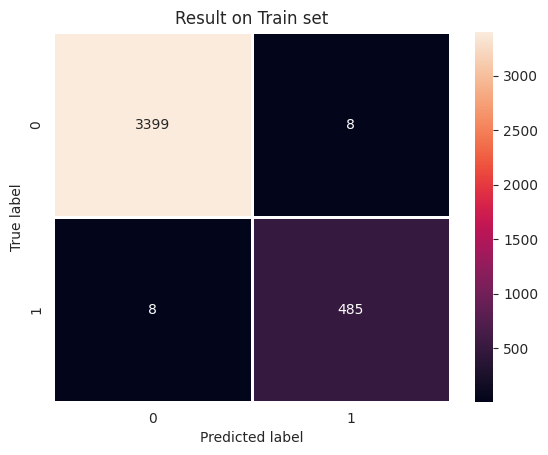

In [27]:
mtx = confusion_matrix(ytrain, ypred_train)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Train set')
plt.show()

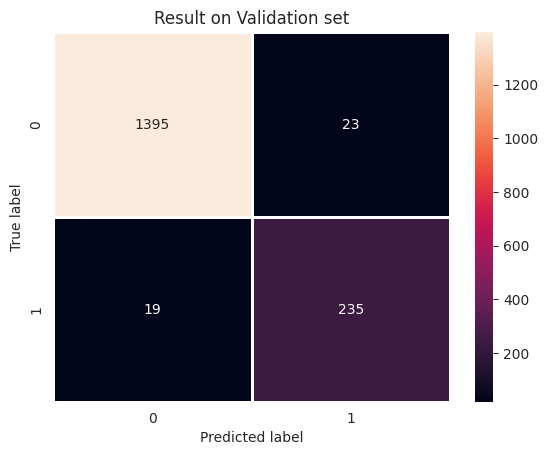

In [28]:
mtx = confusion_matrix(yval, ypred_val)
sns.heatmap(mtx, annot=True, fmt='d', linewidths=.8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Result on Validation set')
plt.show()

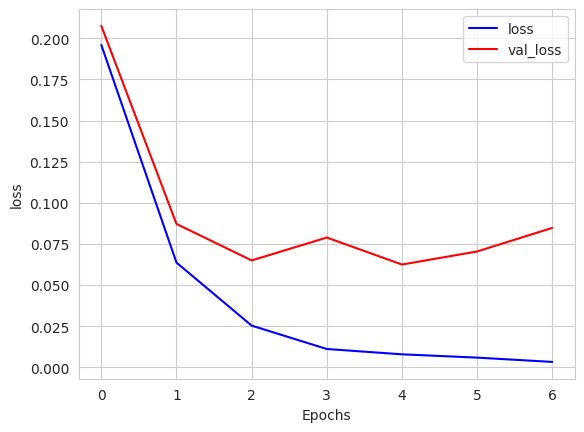

In [29]:
# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b", label='loss')
plt.plot(history.history["val_loss"], color="r", label='val_loss')
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend(loc="upper right")
plt.show()

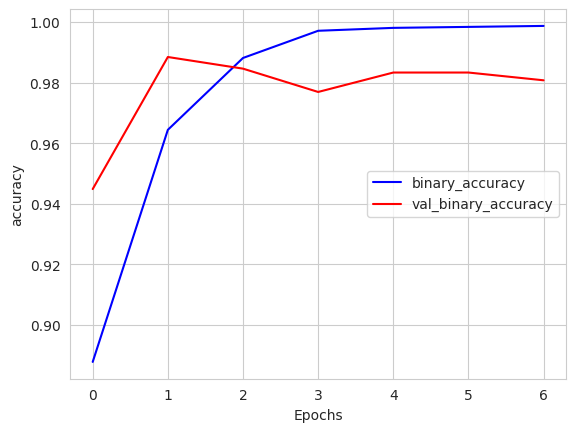

In [30]:
# Visualization of accuracy training
plt.plot(history.history["binary_accuracy"], color="b", label='binary_accuracy')
plt.plot(history.history["val_binary_accuracy"], color="r", label='val_binary_accuracy')
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend(loc="right")
plt.show()